# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
library(viridis)

Loading required package: viridisLite



In [3]:
library(ggpubr)

In [4]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

## functions

In [5]:
getSinglePR <- function(res, alpha, pi_thr, true_edges, colN){
    pc <- quiet(stabilitySelection(rules = res, alpha_error = alpha, pi_thr = pi_thr))
    
    edges <- pc$edges_agg %>% select(x, y, condition, importance, influence, d.x, d.y) %>% 
        subset(condition %in% pc$rules_summary$condition) %>%
        group_by(x, y, condition) %>% 
        summarise(importance= mean(importance), influence = mean(influence*(d.x+d.y)/2)) %>%
        ungroup %>% 
        left_join(select(pc$rules_summary,condition, inN, imp, n), by = 'condition') %>% 
        select(-condition)
    
    edi <- lapply(unique(edges$inN)
                  , function(i, edges, true_edges, colN){
                      suppressMessages(edges <- edges %>% subset(inN >= i) %>% group_by(x, y) %>% 
                                       summarise( inN = max(inN), importance = sum(importance*imp*n)
                                                 , influence = sum(influence*imp*n)/sum(imp*n) ) %>% ungroup)
                      metricsNet(edges = edges, true_edges = true_edges, colN = colN)
                  }, edges = edges, true_edges = true_edges, colN = colN)
    edi <- as.data.frame(do.call(rbind, edi))
    edi$inN <- unique(edges$inN)

    edi$alpha <- alpha
    edi$pi_thr <- pi_thr
    
    return(edi)
}

In [6]:
getSeveralPR <- function(f, alphas, pi_thr, true_edges, colN){
    res <- qread(f)
    
    edi <- lapply( alphas , getSinglePR, res = res$resamp, pi_thr = pi_thr , true_edges = true_edges, colN = colN)
    
    edi <- as.data.frame(do.call(rbind, edi))
    
    edi$seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    edi$id <- paste0(edi$seedN, '_', edi$alpha, '_',edi$pi_thr)
    
    return(edi)
}

In [7]:
file.sources <- list.files('./scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Run

In [8]:
true_edges <- qread('true_edges.qs')
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/', full.names = TRUE)
tmp <- qread(fnames[1])
colN <- colnames(tmp$data$x)

In [9]:
#stopCluster(cluster)
cluster <- makeCluster(7)
clusterEvalQ(cluster, library(qs))
clusterEvalQ(cluster, library(endoR))
clusterEvalQ(cluster, library(tidyverse))
clusterExport(cluster, c('getSeveralPR', 'getSinglePR', 'metricsNet', 'quiet' ))

[[1]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

[[1]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[2]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[4]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[5]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[6]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[7]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"

[[1]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

In [10]:
test_sev <- parLapply(cl = cluster, fnames, getSeveralPR, alpha = c(1, 5, 10, 15, 20)
                   , pi_thr = 0.7, true_edges = true_edges, colN = colN)
test_sev <- do.call(rbind, test_sev)

In [11]:
stopCluster(cluster)

In [12]:
suppressWarnings(av_test <- test_sev %>% group_by(alpha, inN) %>% summarise_all(mean))

In [13]:
test_sev %>% summary

    n_edges            tp               fp               tn        
 Min.   :  2.0   Min.   : 2.000   Min.   :  0.00   Min.   :  6.00  
 1st Qu.: 23.0   1st Qu.: 9.000   1st Qu.: 13.00   1st Qu.: 20.00  
 Median : 66.0   Median :10.000   Median : 47.00   Median : 63.00  
 Mean   :107.3   Mean   : 9.154   Mean   : 50.22   Mean   : 59.78  
 3rd Qu.:169.2   3rd Qu.:10.000   3rd Qu.: 90.00   3rd Qu.: 97.00  
 Max.   :360.0   Max.   :10.000   Max.   :104.00   Max.   :110.00  
       fn              inN             alpha          pi_thr   
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.0   Min.   :0.7  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 5.0   1st Qu.:0.7  
 Median :0.0000   Median : 5.000   Median :10.0   Median :0.7  
 Mean   :0.8461   Mean   : 5.453   Mean   :10.3   Mean   :0.7  
 3rd Qu.:1.0000   3rd Qu.: 8.000   3rd Qu.:15.0   3rd Qu.:0.7  
 Max.   :8.0000   Max.   :10.000   Max.   :20.0   Max.   :0.7  
    seedN                id           
 Length:4912        Length:4912      

# random

In [14]:
## Total number of edges
N <- (length(colN)*length(colN) - length(colN))/2 
## Total number of correct edges
K <- length(true_edges)

In [15]:
random_pr_curve <- function(i){
  set.seed(i)
  random_draw <- urn[sample(1:N)]
  tp <- cumsum(random_draw)
  fp <- 1:N - cumsum(random_draw)
  linfit <- approx(fp, tp, xout = seq(1, N-K, length.out = 1000),ties = max)
  
  return(do.call(cbind, linfit))
}

In [16]:
## Resample
urn <- c(rep(1, K), rep(0, N-K))
B <- 1000
rdm <- list()
for(j in 1:B){
  rdm[[j]] <- random_pr_curve(j)
}

In [17]:
rdm <- as.data.frame(do.call(rbind, rdm))
colnames(rdm)<- c('fp', 'tp')

In [18]:
rdm <- group_by(rdm, fp) %>% summarise(tp_av = mean(tp), tp_sd = sd(tp), tp_qtiles = quantile(tp, 0.99))

`summarise()` ungrouping output (override with `.groups` argument)



In [19]:
rdm %>% dim
rdm %>% head

[1] 1000    4

fp,tp_av,tp_sd,tp_qtiles
<dbl>,<dbl>,<dbl>,<dbl>
1.000000,0.1820000,0.4393963,2
1.109109,0.1935656,0.4404358,2
1.218218,0.2051311,0.4446671,2
1.327327,0.2166967,0.4520007,2
1.436436,0.2282623,0.4622887,2
1.545546,0.2398278,0.4753396,2


# Interpolate

In [20]:
getInterpo <- function(i, raw){
    raw <- subset(raw, seedN == i)
    res <- list()
    
    i <- 1
    for (a in unique(raw$alpha)){
        tmp <- approx(raw$fp[raw$alpha == a]
                       , raw$tp[raw$alpha == a]
                       , xout = seq(1, N-K, length.out = 1000)
                       , ties = max)
        tmp <- as.data.frame(do.call(cbind, tmp))
        colnames(tmp) <- c('fp', 'tp')
        tmp$alpha <- a
        
        # add 0 and max values to the extrapolations
        mafp <- max(tmp$fp[!is.na(tmp$tp)])
        tmp$tp[tmp$fp>mafp] <- max(tmp$tp, na.rm = TRUE) 

        res[[i]] <- tmp
        i <- i+1
    }
    res <- do.call(rbind, res)
    res$seedN <- i
    
    return(res)
}

In [21]:
pr_byseed <- suppressWarnings(lapply(unique(test_sev$seedN), getInterpo, raw = test_sev))

In [22]:
pr_byseed_av <- do.call(rbind, pr_byseed) %>% select(-seedN) %>% group_by(fp, alpha) %>% summarise_all(mean)
pr_byseed_sd <- do.call(rbind, pr_byseed) %>% select(-seedN) %>% group_by(fp, alpha) %>% summarise_all(sd)

In [23]:
pr_forplots <- left_join(pr_byseed_av, pr_byseed_sd, by = c('fp', 'alpha'), suffix = c('_av', '_sd'))

In [24]:
pr_forplots %>% dim
pr_forplots %>% tail

[1] 5000    4

fp,alpha,tp_av,tp_sd
<dbl>,<dbl>,<dbl>,<dbl>
109.8909,20,10,0
110.0000,1,10,0
110.0000,5,10,0
110.0000,10,10,0
110.0000,15,10,0
110.0000,20,10,0


# plots

In [25]:
cols <- plasma(length(unique(av_test$alpha)) + 2)

In [26]:
p <- ggplot(pr_forplots 
             , aes(x = fp, y = tp_av, group = as.factor(alpha), color = as.factor(alpha)))+
geom_hline(yintercept = 10, color = 'lightgrey', linetype = 'dashed')+
geom_line(data = pr_forplots , size = 1)+

geom_ribbon(aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group = alpha, fill = as.factor(alpha)), color = NA
            , alpha = 0.25) +

geom_line(data = rdm, aes(y = tp_av, x = fp), group=NA, color = 'darkgrey')+
geom_ribbon(data = rdm
            , aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2, y = tp_av
                  , group=NULL, color = NULL)
            , alpha = 0.25, fill = 'darkgrey') +

geom_point(data = av_test %>% subset(inN == 7)
           , aes(y = tp, x = fp, fill = as.factor(alpha))
           , size = 4, shape = 21, color = 'black')+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP')+
scale_color_manual(values = cols[-c(1, length(cols))], name = expression(alpha)) +
scale_fill_manual(values = cols[-c(1, length(cols))], name = expression(alpha)) 

Warning message:
“Removed 442 row(s) containing missing values (geom_path).”


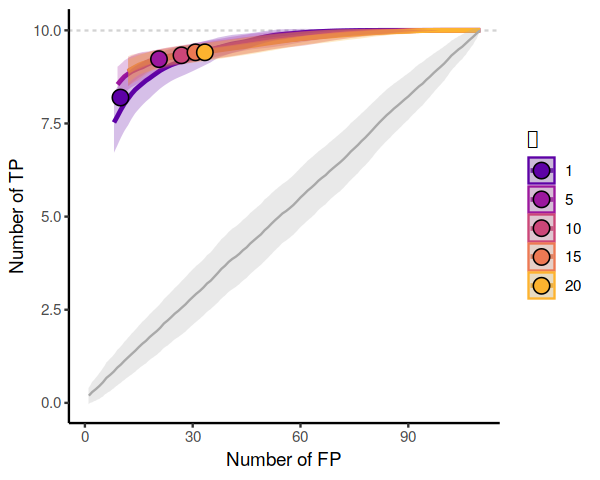

In [27]:
options(repr.plot.width=5, repr.plot.height=4)
p

# check values

In [28]:
getRes <- function(f,alphas, true_edges){
    tmp <- qread(f)
    res <- list()
    
    for (a in alphas){
        # get the new metrics
        quiet(pc <- stabilitySelection(tmp$resamp, alpha_error = a, pi_thr = 0.7))
        cond <- pc$rules_summary %>% subset(inN >= 7, select = condition) %>% unlist
        if (length(cond) > 0){

            imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
            imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
            imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
            suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
            imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
            imp_edges <- lapply(imp_edges, sort) 
            pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 

            # those that should not be but are = in pred_edges but not truth
            tp <- which(sapply(pred_edges, function(x){x %in% true_edges}))
            fp <- which(sapply(pred_edges, function(x){!(x %in% true_edges)}))
            fn <- sum(sapply(true_edges, function(x){!(x %in% pred_edges)}))

            # sum of FP importances
            if(length(fp) > 0) {
                fp_imp <- sum(sapply(imp_edges[fp], function(x){as.numeric(x['importance'])}))
            } else {fp_imp <- 0}
            # sum of TP importances
            if(length(tp) > 0) {
                tp_imp <- sum(sapply(imp_edges[tp], function(x){as.numeric(x['importance'])}))
            } else {tp_imp <- 0}

            res[[as.character(a)]] <- c('alpha' = a, 'rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = length(cond)
                    , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = length(tp), 'fp' = length(fp)
                    , 'fn' = fn)
        } else {
            res[[as.character(a)]] <- c('alpha' = a, 'rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = 0
                    , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0)
        }
    }
    res <- do.call(rbind, res)
    
    return(res)
}

In [29]:
true_edges <- qread('true_edges.qs')
true_edges <- true_edges %>% lapply(sort) %>% 
                sapply(paste, collapse = ' - ')

In [30]:
check <- lapply(fnames, getRes, alphas = c(1,5,10,15,20), true_edges = true_edges)
check <- do.call(rbind, check)

In [31]:
check <- as.data.frame(check) %>% mutate_all(as.numeric)

In [32]:
check$precision <- check$tp/(check$tp+check$fp)
check$recall <- check$tp/(check$tp+check$fn)
check$w_precision <- check$tp_imp/(check$tp_imp+check$fp_imp)

In [33]:
check %>% group_by(alpha) %>% summarise_all(mean) %>% #subset(alpha != 5) %>% 
select(alpha, rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

alpha,rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.88972,12.41,8.45,9.24,2.01,110.6748,15.00461,0.5241038,0.8058485,0.8693998
5,0.88972,19.52,10.18,20.73,0.78,125.4201,21.25651,0.3590535,0.9283030,0.8441093
10,0.88972,23.71,10.51,27.32,0.67,129.2688,24.25346,0.2943439,0.9400909,0.8288906
15,0.88972,26.45,10.65,31.41,0.59,131.4319,25.76046,0.2660498,0.9474697,0.8235837
20,0.88972,28.64,10.76,34.17,0.59,132.7822,26.83755,0.2512741,0.9477727,0.8192289


In [34]:
check %>% group_by(alpha) %>% summarise_all(sd) %>% #subset(alpha != 5) %>% 
select(alpha, rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

alpha,rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01508366,2.605724,1.7371462,5.154423,1.5406610,59.88341,10.68314,0.17863380,0.15125659,0.07861441
5,0.01508366,3.688585,0.9574799,8.376078,0.6126610,58.66924,11.53429,0.12783107,0.05813523,0.07503780
10,0.01508366,4.048432,0.8347866,8.862451,0.5135537,58.30358,11.36617,0.07612521,0.04596511,0.07563503
15,0.01508366,4.279089,0.8453677,9.207041,0.5143398,57.93187,11.46481,0.06381073,0.04605413,0.07357153
20,0.01508366,4.549437,0.8775540,9.844298,0.5143398,57.97339,11.67849,0.05931549,0.04582264,0.07381397


In [35]:
check %>% count(alpha)

alpha,n
<dbl>,<int>
1,100
5,100
10,100
15,100
20,100
